/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


                                           track_name     artist_name  \
86953   Sunflower - Spider-Man: Into the Spider-Verse     Post Malone   
107875                                  Calma - Remix      Pedro Capó   
107806  Sunflower - Spider-Man: Into the Spider-Verse     Post Malone   
138916                                        Secreto        Anuel Aa   
66741                                      Adan y Eva    Paulo Londra   
107816                                         Sucker  Jonas Brothers   
107988                                   Desconocidos     Mau y Ricky   
138922                                        Amanece        Anuel Aa   
66750                                        Adictiva    Daddy Yankee   
108166                                          Te Vi         Piso 21   
86974                                       Moonlight    XXXTENTACION   
9042                                           Sucker  Jonas Brothers   
66617                                       Moonlig

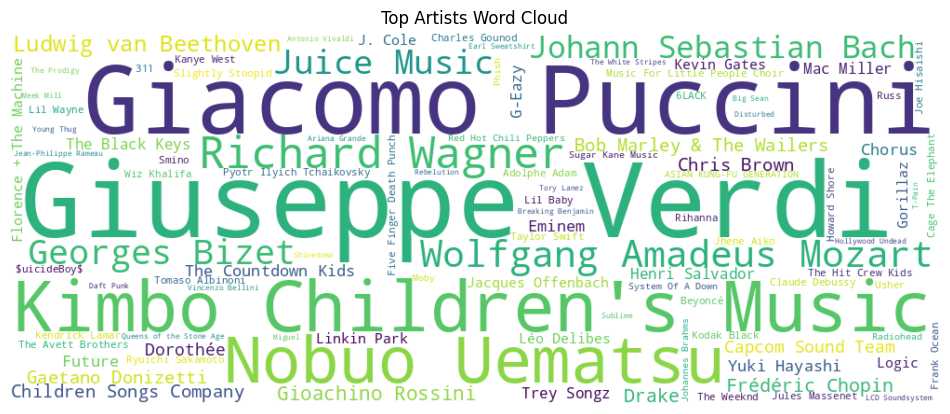

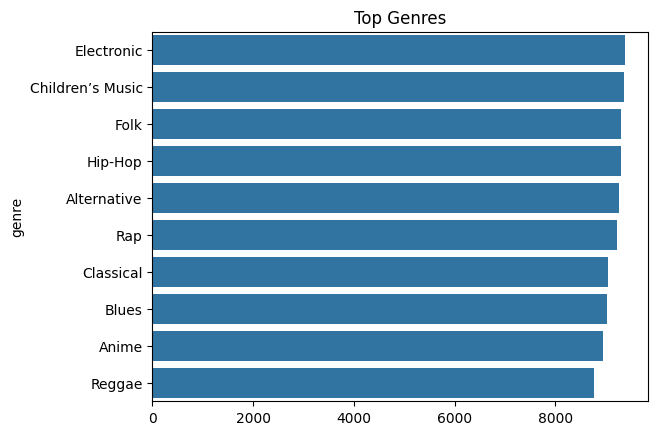

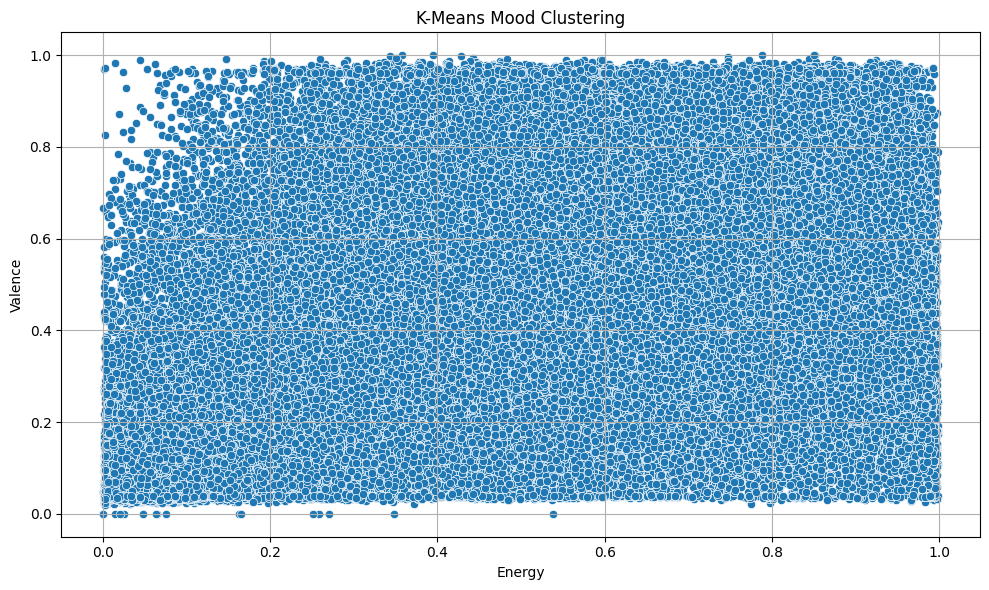

Naive Bayes Report:
               precision    recall  f1-score   support

       happy       0.49      0.83      0.62     12235
         sad       0.74      0.36      0.49     16431

    accuracy                           0.56     28666
   macro avg       0.62      0.60      0.55     28666
weighted avg       0.64      0.56      0.54     28666

KNN Report:
               precision    recall  f1-score   support

       happy       0.56      0.55      0.55     12235
         sad       0.67      0.68      0.67     16431

    accuracy                           0.62     28666
   macro avg       0.61      0.61      0.61     28666
weighted avg       0.62      0.62      0.62     28666

Decision Tree Report:
               precision    recall  f1-score   support

       happy       1.00      1.00      1.00     12235
         sad       1.00      1.00      1.00     16431

    accuracy                           1.00     28666
   macro avg       1.00      1.00      1.00     28666
weighted avg     

In [3]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np

# Step 2: Load Dataset
spotify_df = pd.read_csv('SpotifyFeatures.csv')  # Replace with actual file path

# Step 3: Preprocessing
spotify_df.dropna(subset=['valence', 'energy', 'danceability', 'popularity', 'artist_name', 'track_name'], inplace=True)
spotify_df['artist_name'] = spotify_df['artist_name'].astype(str).apply(lambda x: x.strip())

# ---------- Feature Engineering & Transformation ----------
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Standardization
scaler = StandardScaler()
spotify_df_std = pd.DataFrame(scaler.fit_transform(spotify_df[features]), columns=[f + '_std' for f in features])

# Normalization
norm_scaler = MinMaxScaler()
spotify_df_norm = pd.DataFrame(norm_scaler.fit_transform(spotify_df[features]), columns=[f + '_norm' for f in features])

# Log Transformation (handling skew)
spotify_df_log = spotify_df[features].apply(lambda x: np.log1p(x))  # log(1+x)

# Aggregation Example (Mean energy by genre)
if 'genre' in spotify_df.columns:
    genre_energy = spotify_df.groupby('genre')['energy'].mean().sort_values(ascending=False)

# Discretization/Binarization using KBins
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
spotify_df_disc = pd.DataFrame(discretizer.fit_transform(spotify_df[['valence']]), columns=['valence_binned'])

# Sampling (Random 10%)
spotify_sample = spotify_df.sample(frac=0.1, random_state=42)

# ---------- Mood Recommender ----------
def recommend_songs_by_mood(mood):
    mood_criteria = {
        'happy': {'valence': (0.7, 1.0)},
        'sad': {'valence': (0.0, 0.3)},
        'energetic': {'energy': (0.7, 1.0)},
        'calm': {'energy': (0.0, 0.4)},
        'party': {'danceability': (0.7, 1.0), 'energy': (0.7, 1.0)}
    }

    filters = mood_criteria.get(mood.lower())
    if not filters:
        return pd.DataFrame({'Message': [f"No recommendations for mood: {mood}"]})

    filtered = spotify_df.copy()
    for feature, (low, high) in filters.items():
        filtered = filtered[(filtered[feature] >= low) & (filtered[feature] <= high)]

    top_songs = filtered.sort_values(by='popularity', ascending=False).head(15)
    return top_songs[['track_name', 'artist_name', 'valence', 'energy', 'danceability', 'popularity']]

mood = 'happy'
song_recs = recommend_songs_by_mood(mood)
print(song_recs)

# ---------- Visualization ----------
# Word Cloud
artist_freq = pd.Series(spotify_df['artist_name']).value_counts().head(100)
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(artist_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Artists Word Cloud')
plt.show()

# Genre Count
if 'genre' in spotify_df.columns:
    genre_counts = spotify_df['genre'].value_counts().head(10)
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title("Top Genres")
    plt.show()

# K-Means Clustering Visualization
plt.figure(figsize=(10,6))
sns.scatterplot(data=spotify_df, x='energy', y='valence')
plt.title("K-Means Mood Clustering")
plt.xlabel("Energy")
plt.ylabel("Valence")
plt.grid(True)
plt.tight_layout()
plt.show()


# ---------- Mood Classification (Supervised ML) ----------
# For demo purposes: binarize valence for classification
spotify_df['mood_label'] = spotify_df['valence'].apply(lambda x: 'happy' if x > 0.5 else 'sad')
X = spotify_df[features]
y = spotify_df['mood_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb))

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Report:\n", classification_report(y_test, y_pred_knn))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dt))

# ---------- Apriori Algorithm ----------
# Binarize continuous features
spotify_bin = pd.DataFrame()
for col in ['energy', 'danceability', 'valence']:
    spotify_bin[col + '_high'] = spotify_df[col] > spotify_df[col].median()

frequent_items = apriori(spotify_bin, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1.0)
print("Apriori Rules:\n", rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())
